In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
import pickle
%matplotlib inline

import avocado
from tqdm import tqdm

In [3]:
data_path = os.path.join(str(os.getcwd()), '..', 'data', "plasticc", "data", "plasticc_raw")
plasticc_train_meta = pd.read_csv(os.path.join(data_path, "plasticc_train_metadata.csv.gz"))
print(plasticc_train_meta.columns)
plasticc_train_meta.shape

Index(['object_id', 'ra', 'decl', 'ddf_bool', 'hostgal_specz',
       'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'target',
       'true_target', 'true_submodel', 'true_z', 'true_distmod',
       'true_lensdmu', 'true_vpec', 'true_rv', 'true_av', 'true_peakmjd',
       'libid_cadence', 'tflux_u', 'tflux_g', 'tflux_r', 'tflux_i', 'tflux_z',
       'tflux_y'],
      dtype='object')


(7848, 26)

In [4]:
plasticc_augment_meta = avocado.load("plasticc_augment_ddf_100", metadata_only=True, verify_input_chunks=False)
print(plasticc_augment_meta.metadata.columns)
plasticc_augment_meta.metadata.shape

Index(['ra', 'decl', 'ddf', 'host_specz', 'host_photoz', 'host_photoz_error',
       'mwebv', 'class', 'true_submodel', 'redshift', 'true_distmod',
       'true_lensdmu', 'true_vpec', 'true_rv', 'true_av', 'true_peakmjd',
       'libid_cadence', 'tflux_u', 'tflux_g', 'tflux_r', 'tflux_i', 'tflux_z',
       'tflux_y', 'galactic', 'augment_brightness', 'reference_object_id'],
      dtype='object')


(1307, 26)

Index(['ra', 'decl', 'ddf', 'host_specz', 'host_photoz', 'host_photoz_error',
       'mwebv', 'class', 'true_submodel', 'redshift', 'true_distmod',
       'true_lensdmu', 'true_vpec', 'true_rv', 'true_av', 'true_peakmjd',
       'libid_cadence', 'tflux_u', 'tflux_g', 'tflux_r', 'tflux_i', 'tflux_z',
       'tflux_y', 'galactic'],
      dtype='object')


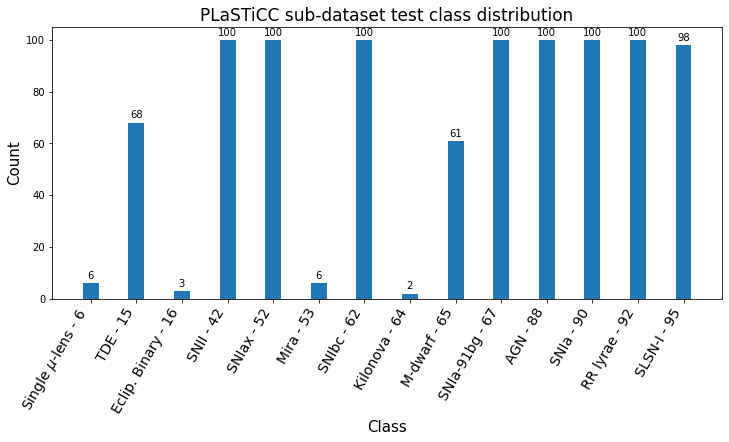

In [33]:
plasticc_test_meta = avocado.load("plasticc_test_ddf_100", metadata_only=True, verify_input_chunks=False)
print(plasticc_test_meta.metadata.columns)
plasticc_test_meta.metadata.shape

class_count_ddf0, class_count_wfd = get_counts(plasticc_test_meta.metadata, key="ddf", key2="class")
labels_cc1, values_cc1 = zip(*sorted(class_count_ddf0.items()))
labels = [plot_labels_short[x] for x in labels_cc1]
indexes = np.arange(len(labels_cc1))
width = 0.35 
fig, ax = plt.subplots(figsize=(12, 5))
rects1 = ax.bar(indexes, values_cc1, width)
ax.set_xticks(indexes)
ax.set_xticklabels(labels, rotation=60, ha="right", fontsize=14)
ax.set_xlabel("Class", fontsize=15)
ax.set_ylabel("Count", fontsize=15)
ax.set_title("PLaSTiCC sub-dataset test class distribution", fontsize=17)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height + 1,
                    '%d' % int(height),
                    ha='center', va='bottom')

autolabel(rects1)

In [24]:
plasticc_train_meta = avocado.load("plasticc_train_ddf_100", metadata_only=True, verify_input_chunks=False)
print(plasticc_train_meta.metadata.columns)
plasticc_train_meta.metadata.shape

Index(['ra', 'decl', 'ddf', 'host_specz', 'host_photoz', 'host_photoz_error',
       'mwebv', 'class', 'true_submodel', 'redshift', 'true_distmod',
       'true_lensdmu', 'true_vpec', 'true_rv', 'true_av', 'true_peakmjd',
       'libid_cadence', 'tflux_u', 'tflux_g', 'tflux_r', 'tflux_i', 'tflux_z',
       'tflux_y', 'galactic'],
      dtype='object')


(856, 24)

In [19]:
plot_labels_short = {
    6: 'Single $\mu$-lens - 6',
    15: 'TDE - 15',
    16: 'Eclip. Binary - 16',
    42: 'SNII - 42',
    52: 'SNIax - 52',
    53: 'Mira - 53',
    62: 'SNIbc - 62',
    64: 'Kilonova - 64',
    65: 'M-dwarf - 65',
    67: 'SNIa-91bg - 67',
    88: 'AGN - 88',
    90: 'SNIa - 90',
    92: 'RR lyrae - 92',
    95: 'SLSN-I - 95',
    99: 'Unknown - 99',
    991: '$\mu$lens-Binary - 991',
    992: 'ILOT - 992',
    993: 'CaRT - 993',
    994: 'PISN - 994',
    995: '$\mu$lens-String'
}

merged_labels = {
    6: 'Single $\mu$-lens',
    15: 'TDE',
    16: 'Short period VS',
    42: 'SN',
    52: 'SN',
    53: 'Short period VS',
    62: 'SN',
    64: 'SN',
    65: 'M-dwarf',
    67: 'SN',
    88: 'AGN',
    90: 'SN',
    92: 'Short period VS',
    95: 'SN',
    99: 'Unknown',
    991: 'Unknown',
    992:'Unknown',
    993:'Unknown',
    994:'Unknown',
    995:'Unknown',
}


def plot_labels_tuple(class_count1, class_count2, label1, label2, labels_names, log_scale=False, show_lines=False, title="Multi-band Time Series count per class"):
    labels_cc1, values_cc1 = zip(*sorted(class_count1.items()))
    labels_cc2, values_cc2 = zip(*sorted(class_count2.items()))
    
#     if log_scale:
#         values_cc1 = np.log(values_cc1)
#         values_cc2 = np.log(values_cc2)
    
    if labels_names is not None:
        labels = [labels_names[x] for x in labels_cc1]
    else:
        labels = labels_cc1
    
    indexes = np.arange(len(labels_cc1))
    width = 0.35 
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    rects1 = ax.bar(indexes, values_cc1, width)
    rects2 = ax.bar(indexes + width, values_cc2, width)
    
    ax.set_xticks(indexes + width / 2)
#     ax.set_ylim([0, max(np.max(values_cc1), np.max(values_cc2)) + 150])
    ax.set_xticklabels(labels, rotation=60, ha="right", fontsize=14)
    
    ax.set_xlabel("Class", fontsize=15)
    ax.set_ylabel("Count", fontsize=15)
    ax.set_title(title, fontsize=17)
    
    ax.legend((rects1[0], rects2[0]), (label1, label2), fontsize=15)
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height + 1,
                    '%d' % int(height),
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    if log_scale:
        ax.set_yscale('log')
    ax.set_ylim([0, 110])
    plt.tight_layout()
    if show_lines:
        ax.axhline(500, color="blue")
        ax.axhline(5000, color="orange")
#     
#     plt.xlabel("class", fontsize=15)
#     plt.ylabel("count", fontsize=15)
#     plt.title(title, fontsize=17)

def get_counts(df_meta, key="ddf", key2="target"):
    wfd = 0
    ddf = 1

    df_meta_ddf = df_meta[df_meta[key] == ddf]
    df_meta_wfd = df_meta[df_meta[key] == wfd]

    class_count_ddf = defaultdict(int)
    for l in df_meta_ddf[key2]:
        class_count_ddf[l] += 1

    class_count_wfd = defaultdict(int)
    for l in df_meta_wfd[key2]:
        class_count_wfd[l] += 1

    return class_count_ddf, class_count_wfd


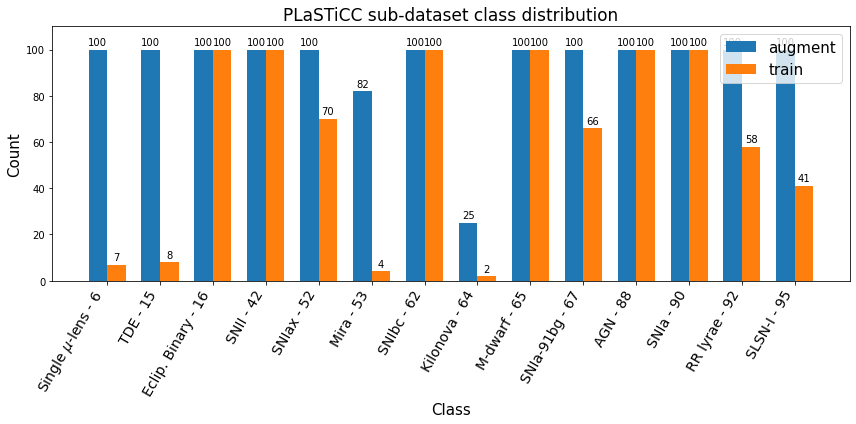

In [22]:
class_count_ddf1, class_count_wfd = get_counts(plasticc_augment_meta.metadata, key="ddf", key2="class")
class_count_ddf2, class_count_wfd = get_counts(plasticc_train_meta.metadata, key="ddf", key2="class")
log_scale = False
show_lines = False
plot_labels_tuple(class_count_ddf1, class_count_ddf2, "augment", "train", plot_labels_short, log_scale=log_scale, show_lines=show_lines,
                  title="PLaSTiCC sub-dataset class distribution")

In [8]:
log_scale = True
show_lines = False
class_count_ddf, class_count_wfd = get_counts(plasticc_test_meta.metadata, key="ddf", key2="class")
plot_labels_tuple(class_count_ddf, class_count_wfd, "DDF", "WFD", plot_labels_short, log_scale=log_scale, show_lines=show_lines, title="PLaSTiCC test set classes")

class_count_ddf_merged = defaultdict(int)
class_count_wfd_merged = defaultdict(int)
for key, val in class_count_ddf.items():
    class_count_ddf_merged[merged_labels[key]] += val

for key, val in class_count_wfd.items():
    class_count_wfd_merged[merged_labels[key]] += val
    
plot_labels_tuple(class_count_ddf_merged, class_count_wfd_merged, "DDF", "WFD", None, log_scale=log_scale, show_lines=show_lines, title="PLaSTiCC test set merged classes")

ValueError: not enough values to unpack (expected 2, got 0)

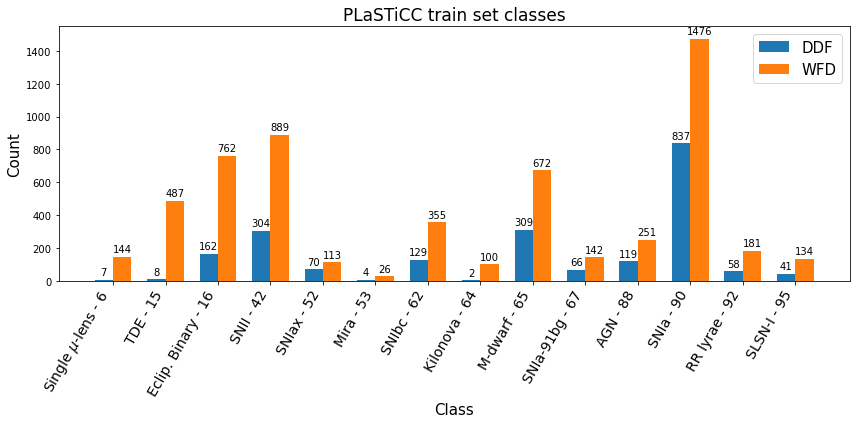

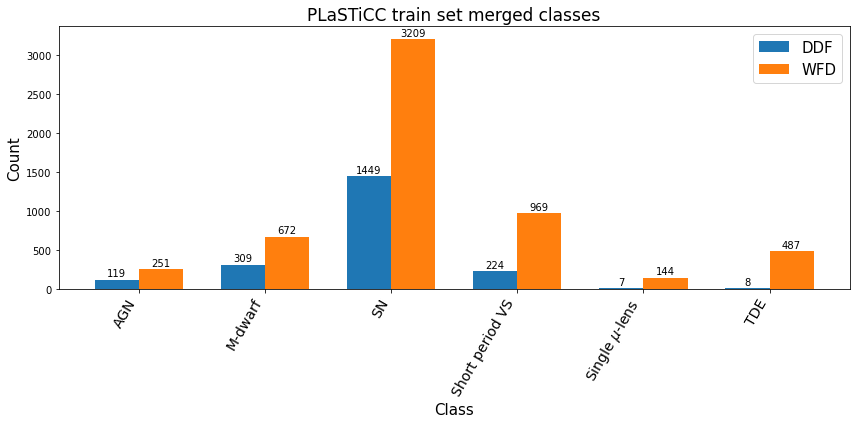

In [15]:
log_scale = False
show_lines = False
class_count_ddf, class_count_wfd = get_counts(plasticc_train_meta.metadata, key="ddf", key2="class")
plot_labels_tuple(class_count_ddf, class_count_wfd, "DDF", "WFD", plot_labels_short, log_scale=log_scale, show_lines=show_lines, title="PLaSTiCC train set classes")

class_count_ddf_merged = defaultdict(int)
class_count_wfd_merged = defaultdict(int)
for key, val in class_count_ddf.items():
    class_count_ddf_merged[merged_labels[key]] += val

for key, val in class_count_wfd.items():
    class_count_wfd_merged[merged_labels[key]] += val
    
plot_labels_tuple(class_count_ddf_merged, class_count_wfd_merged, "DDF", "WFD", None, log_scale=log_scale, show_lines=show_lines, title="PLaSTiCC train set merged classes")

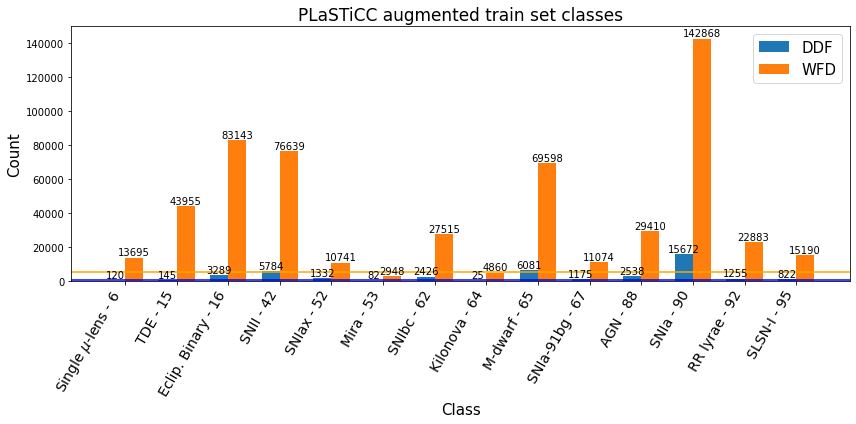

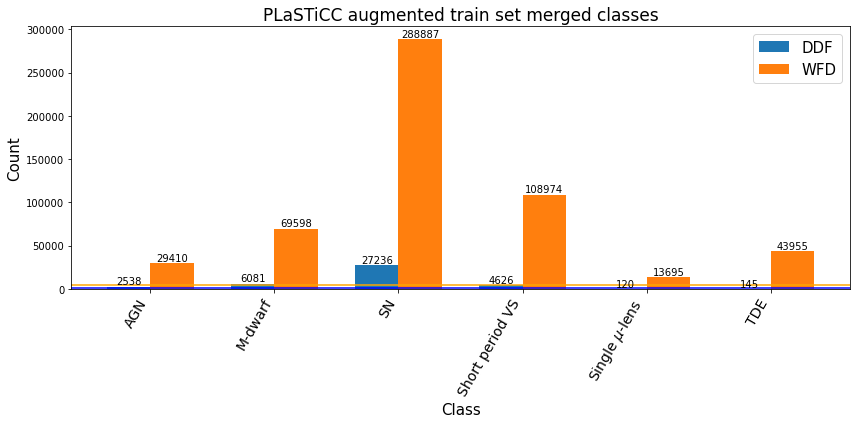

In [16]:
log_scale = False
show_lines = True
class_count_ddf, class_count_wfd = get_counts(plasticc_augment_meta.metadata, key="ddf", key2="class")
plot_labels_tuple(class_count_ddf, class_count_wfd, "DDF", "WFD", plot_labels_short, log_scale=log_scale, show_lines=show_lines,
                 title="PLaSTiCC augmented train set classes")

class_count_ddf_merged = defaultdict(int)
class_count_wfd_merged = defaultdict(int)
for key, val in class_count_ddf.items():
    class_count_ddf_merged[merged_labels[key]] += val

for key, val in class_count_wfd.items():
    class_count_wfd_merged[merged_labels[key]] += val
    
plot_labels_tuple(class_count_ddf_merged, class_count_wfd_merged, "DDF", "WFD", None, log_scale=log_scale, show_lines=show_lines,
                 title="PLaSTiCC augmented train set merged classes")

## Simple case
- generate dataset of WFD survey using 100 real objects on each merged class for train1
- generate dataset of WFD survey using the previous 100 real objects plus 100 augmentes objectes produced from those 100, selected randomly.
- generate dataset of WFD survey using 100 real objects on each merged class from test set to test

- DDF survey using 50/all objects per class from train set
- DDF survey using 50/all objects per class from test set
- DDF survey using 50/all objects per class fron augmented set, including the used in train set

In [55]:
merged_labels = {
    6: 'Single microlens',
    15: 'TDE',
    16: 'Short period VS',
    42: 'SN',
    52: 'SN',
    53: 'Short period VS',
    62: 'SN',
    64: 'SN',
    65: 'M-dwarf',
    67: 'SN',
    88: 'AGN',
    90: 'SN',
    92: 'Short period VS',
    95: 'SN',
    99: 'Unknown',
    991: 'Unknown',
    992:'Unknown',
    993:'Unknown',
    994:'Unknown',
    995:'Unknown',
}

merged_labels_to_num = {
    'Single microlens': 1,
    'TDE': 2,
    'Short period VS': 3,
    'SN': 4,
    'M-dwarf': 5,
    'AGN': 6,
    'Unknown': 99
}

def select_real_objects_id(df_metadata, classes):
    wfd = df_metadata[df_metadata["ddf"] == 1].copy()
#     wfd["merged_class"] = [merged_labels_to_num[merged_labels[x]] for x in wfd["class"]]
#     merged_classes = np.unique(wfd["merged_class"].to_numpy())
#     print(merged_classes, classes)
    wfd_objects_id = None
    labels = None
    for c in classes:
        idxs = wfd[wfd["class"]==c].index.to_numpy()
        if len(idx) > 50:
            idxs = np.random.choice(idxs, size=50, replace=False)
            
        if wfd_objects_id is None:
            wfd_objects_id = idxs.copy()
            labels = np.full(len(idxs), c)
        else:
            wfd_objects_id = np.append(wfd_objects_id, idxs)
            labels = np.append(labels, np.full(len(idxs), c))
    return wfd_objects_id, labels

def add_augmented_versions_random(df_metadata, wfd):
    aug = {}
    for obj in tqdm(wfd):
        df = df_metadata[df_metadata["reference_object_id"] == obj]
        c = int(df["class"][0])
        c_m = merged_labels_to_num[merged_labels[c]]
        values = df.index.to_numpy()
        if obj in values:
            values = np.delete(values, np.where(values == obj)[0][0])
        if c_m not in aug:
            aug[c_m] = values.copy()
        else:
            aug[c_m] = np.append(aug[c_m], values)
            
    news = None
    for k, v in aug.items():
        idxs = np.random.choice(v, size=100, replace=False)
        if news is None:
            news = idxs.copy()
        else:
            news = np.append(news, idxs)
            
    return news
    

classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
wfd_train, wfd_train_labels = select_real_objects_id(plasticc_train_meta.metadata, classes)
wfd_test, wfd_test_labels = select_real_objects_id(plasticc_test_meta.metadata, classes)
print(len(wfd_train), len(wfd_test))
aug = add_augmented_versions_random(plasticc_augment_meta.metadata, wfd_train)
wfd_aug_train = np.append(wfd_train, aug)


[1 2 3 4 5 6] [1, 2, 3, 4, 5, 6]
[ 1  2  3  4  5  6 99] [1, 2, 3, 4, 5, 6]


  0%|▍                                                                                 | 3/600 [00:00<00:23, 25.82it/s]

600 600


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:23<00:00, 25.82it/s]


NameError: name 'wfd_aug' is not defined

In [68]:
len(wfd_aug_train), len(np.unique(aug))

(1200, 600)

In [71]:
def downscale_process_chunk(chunk, name, out_name, num_chunks, objects_id):
    
    dataset = avocado.load(
        name,
        chunk=chunk,
        num_chunks=num_chunks,
    )
    selected_objects = []
    for reference_object in tqdm(
            dataset.objects, desc="Object", dynamic_ncols=True
        ):
        if reference_object.metadata["object_id"] in objects_id:
            selected_objects.append(reference_object)
    if len(selected_objects)>0:
        out_dataset = avocado.Dataset.from_objects(
            out_name,
            selected_objects,
            chunk=dataset.chunk,
            num_chunks=dataset.num_chunks,
        )
    
        out_dataset.write()
        
def pd_dataset_to_arr(dataset):
    res = []
    labels = []
    for ref in dataset.objects:
        labels.append(ref.metadata["class"])
        res.append(TimeSeriesObject.from_astronomical_object(ref))
        
    return res, labels
    
def classify(train_name, test_name, num_chunks1, num_chunks2):
    for chunk2 in range(num_chunks2):
        dataset_test = avocado.load(test_name, chunk=chunk2, num_chunks=num_chunks2)
        d_test, l_test = pd_dataset_to_arr(dataset_test)
        min_dist = np.inf
        lbl = -1
        for chunk1 in range(num_chunks1):
            dataset_train = avocado.load(train_name,chunk=chunk1, num_chunks=num_chunks1)
            d_train, l_train = pd_dataset_to_arr(dataset_train)
#             for i in range(len(d_train)):
#                 dist = 

In [59]:
num_chunks = 50
name = "plasticc_train"
out_name = "plasticc_train_wfd_600"

for chunk in tqdm(range(num_chunks), desc='Chunk',
                          dynamic_ncols=False):
    downscale_process_chunk(chunk, name, out_name, num_chunks, wfd_train)

Chunk: 100%|███████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.41it/s]


In [64]:
num_chunks = 100
name = "plasticc_test"
out_name = "plasticc_test_wfd_600_v2"

for chunk in tqdm(range(num_chunks), desc='Chunk',
                          dynamic_ncols=False):
    downscale_process_chunk(chunk, name, out_name, num_chunks, wfd_test)

Chunk: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [28:03<00:00, 16.84s/it]


In [69]:
num_chunks = 100
name = "plasticc_augment"
out_name = "plasticc_augment_wfd_600"

for chunk in tqdm(range(num_chunks), desc='Chunk',
                          dynamic_ncols=False):
    downscale_process_chunk(chunk, name, out_name, num_chunks, aug)

Chunk: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [06:25<00:00,  3.85s/it]


In [66]:
%debug

> c:\programdata\miniconda3\envs\py37\lib\site-packages\pandas\io\pytables.py(3888)create_axes()
   3886                         "cannot match existing table structure for [{items}] "
   3887                         "on appending data".format(
-> 3888                             items=(",".join(pprint_thing(item) for item in items))
   3889                         )
   3890                     )



ipdb>  up


> c:\programdata\miniconda3\envs\py37\lib\site-packages\pandas\io\pytables.py(4194)write()
   4192         # create the axes
   4193         self.create_axes(
-> 4194             axes=axes, obj=obj, validate=append, min_itemsize=min_itemsize, **kwargs
   4195         )
   4196 



ipdb>  up


> c:\programdata\miniconda3\envs\py37\lib\site-packages\pandas\io\pytables.py(1525)_write_to_group()
   1523 
   1524         # write the object
-> 1525         s.write(obj=value, append=append, complib=complib, **kwargs)
   1526 
   1527         if s.is_table and index:



ipdb>  up


> c:\programdata\miniconda3\envs\py37\lib\site-packages\pandas\io\pytables.py(1059)append()
   1057             format = get_option("io.hdf.default_format") or "table"
   1058         kwargs = self._validate_format(format, kwargs)
-> 1059         self._write_to_group(key, value, append=append, dropna=dropna, **kwargs)
   1060 
   1061     def append_to_multiple(



ipdb>  up


> c:\programdata\miniconda3\envs\py37\lib\site-packages\pandas\io\pytables.py(269)<lambda>()
    267 
    268     if append:
--> 269         f = lambda store: store.append(key, value, **kwargs)
    270     else:
    271         f = lambda store: store.put(key, value, **kwargs)



ipdb>  up


> c:\programdata\miniconda3\envs\py37\lib\site-packages\pandas\io\pytables.py(278)to_hdf()
    276             path_or_buf, mode=mode, complevel=complevel, complib=complib
    277         ) as store:
--> 278             f(store)
    279     else:
    280         f(path_or_buf)



ipdb>  up


> c:\programdata\miniconda3\envs\py37\lib\site-packages\pandas\core\generic.py(2530)to_hdf()
   2528         from pandas.io import pytables
   2529 
-> 2530         pytables.to_hdf(path_or_buf, key, self, **kwargs)
   2531 
   2532     def to_msgpack(self, path_or_buf=None, encoding="utf-8", **kwargs):



ipdb>  up


> c:\programdata\miniconda3\envs\py37\lib\site-packages\avocado-0.1-py3.7.egg\avocado\utils.py(370)write_dataframe()
    368 
    369     dataframe.to_hdf(
--> 370         store, key, mode="a", append=append, format="table", data_columns=[chunk_column]
    371     )
    372 



ipdb>  up


> c:\programdata\miniconda3\envs\py37\lib\site-packages\avocado-0.1-py3.7.egg\avocado\dataset.py(466)write()
    464             num_chunks=self.num_chunks,
    465             overwrite=overwrite,
--> 466             **kwargs
    467         )
    468 



ipdb>  up


> <ipython-input-58-cfc231b6c284>(22)downscale_process_chunk()
     18             chunk=dataset.chunk,
     19             num_chunks=dataset.num_chunks,
     20         )
     21 
---> 22         out_dataset.write()



ipdb>  print(out_dataset)


ipdb>  print(out_dataset.metada)


*** AttributeError: 'Dataset' object has no attribute 'metada'


ipdb>  print(out_dataset.metadata)


                                         ra     decl    ddf  host_specz  \
object_id                                                                 
plasticc_001516088                  51.5039 -13.8620  False    0.000000   
plasticc_001854631                 285.4688 -32.6198  False    0.000000   
plasticc_001854631_aug_OWCIEozzfO  285.4688 -32.6198  False    0.000000   
plasticc_002204069                 161.1914  -2.3880  False    2.386000   
plasticc_002379457                 333.5427 -52.9946  False    0.290000   
plasticc_002379457_aug_TwdkuSrPBi  333.5427 -52.9946  False    0.276359   
plasticc_002580406                 123.3984 -24.1329  False    0.000000   
plasticc_002585803                  30.5859 -17.1138  False    0.610000   
plasticc_002585803_aug_BWhSTrTZVF   30.5859 -17.1138  False    0.798639   

                                   host_photoz  host_photoz_error     mwebv  \
object_id                                                                     
plasticc_0015160

ipdb>  exit


### Usage

Although the code augmented all classes in the same proporsion, resulting in an imbalanced augmented dataset, we wont use all the augmented data of every class. More specially, we will downscale the dataset until we get a more balanced dataset.

- For WFD survey: downscale to 5.000 samples on each class (if class has less than 5.000 samples, use all)
- For DDF survey: downscale to 500 samples on each class (if class has less than 500 samples, use all)

WE will also predict on two different classification:
- Real simulated classes (14 in total)
- Merged classes (6 in total: ANG, M-dwarf, SN, Short period VS, single microlens, TDE)


And finaly, for fast test evaluation, we will make a sub-dataset of:
- 500 samples on each class for WFD
- 100 samples on each class for DDF

In [33]:
def plot_labels_single(class_count1, label1, labels_names, log_scale=False, show_lines=False, title="Multi-band Time Series count per class"):
    labels_cc1, values_cc1 = zip(*sorted(class_count1.items()))
    
#     if log_scale:
#         values_cc1 = np.log(values_cc1)
#         values_cc2 = np.log(values_cc2)
    
    if labels_names is not None:
        labels = [labels_names[x] for x in labels_cc1]
    else:
        labels = labels_cc1
    
    indexes = np.arange(len(labels_cc1))
    width = 0.35 
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    rects1 = ax.bar(indexes, values_cc1, width)
    
    ax.set_xticks(indexes + width / 2)
#     ax.set_ylim([0, max(np.max(values_cc1), np.max(values_cc2)) + 150])
    ax.set_xticklabels(labels, rotation=60, ha="right", fontsize=14)
    
    ax.set_xlabel("Class", fontsize=15)
    ax.set_ylabel("Count", fontsize=15)
    ax.set_title(title, fontsize=17)
    
#     ax.legend((rects1[0]), (label1), fontsize=15)
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height + 15,
                    '%d' % int(height),
                    ha='center', va='bottom')

    autolabel(rects1)
    if log_scale:
        ax.set_yscale('log')
    plt.tight_layout()
    if show_lines:
        ax.axhline(500, color="blue")
        ax.axhline(5000, color="orange")
#     
#     plt.xlabel("class", fontsize=15)
#     plt.ylabel("count", fontsize=15)
#     plt.title(title, fontsize=17)

def get_counts_single(df_meta, key="ddf", value=1, key2="target"):

    df_meta_ddf = df_meta[df_meta[key] == value]

    class_count_ddf = defaultdict(int)
    for l in df_meta_ddf[key2]:
        class_count_ddf[l] += 1

    return class_count_ddf

Index(['ra', 'decl', 'ddf', 'host_specz', 'host_photoz', 'host_photoz_error',
       'mwebv', 'class', 'true_submodel', 'redshift', 'true_distmod',
       'true_lensdmu', 'true_vpec', 'true_rv', 'true_av', 'true_peakmjd',
       'libid_cadence', 'tflux_u', 'tflux_g', 'tflux_r', 'tflux_i', 'tflux_z',
       'tflux_y', 'galactic', 'augment_brightness', 'reference_object_id'],
      dtype='object')


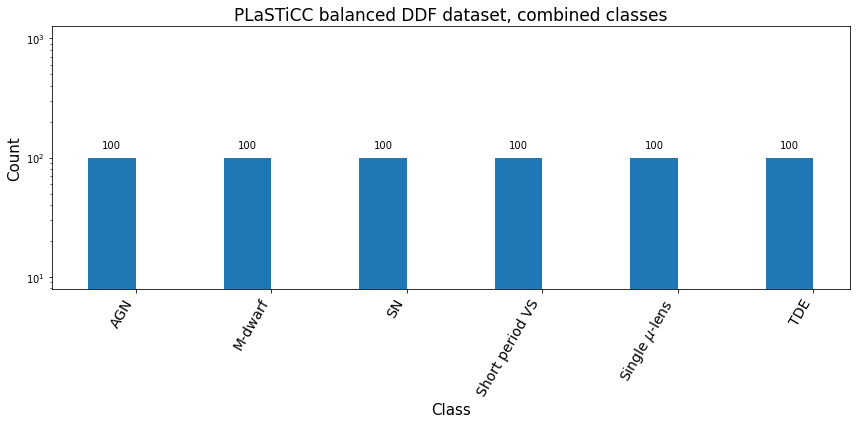

In [38]:
plasticc_augment_meta = avocado.load("plasticc_balanced_combined_classes_small_ddf", metadata_only=True, verify_input_chunks=False)
print(plasticc_augment_meta.metadata.columns)
plasticc_augment_meta.metadata.shape

class_count_ddf = get_counts_single(plasticc_augment_meta.metadata, key="ddf", value=1, key2="class")

class_count_ddf_merged = defaultdict(int)
for key, val in class_count_ddf.items():
    class_count_ddf_merged[merged_labels[key]] += val

plot_labels_single(class_count_ddf_merged, "DDF", None, log_scale=True, show_lines=False,
                 title="PLaSTiCC balanced DDF dataset, combined classes")

Index(['object_id', 'time', 'flux', 'flux_error', 'detected', 'band',
       'reference_time', 'model_flux', 'model_flux_error'],
      dtype='object')


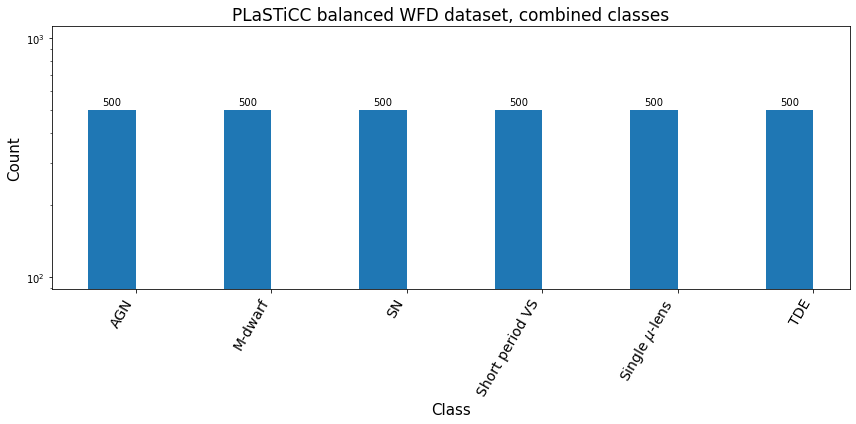

In [43]:
plasticc_augment_meta = avocado.load("plasticc_balanced_combined_classes_small_wfd", metadata_only=False, verify_input_chunks=False)
print(plasticc_augment_meta.objects[0].observations.columns)

class_count_ddf = get_counts_single(plasticc_augment_meta.metadata, key="ddf", value=0, key2="class")

class_count_ddf_merged = defaultdict(int)
for key, val in class_count_ddf.items():
    class_count_ddf_merged[merged_labels[key]] += val

plot_labels_single(class_count_ddf_merged, "WFD", None, log_scale=True, show_lines=False,
                 title="PLaSTiCC balanced WFD dataset, combined classes")

In [80]:
df = plasticc_augment_meta.objects[0].observations
bands = np.unique(df["band"])
# df.plot("time", "flux", fmt=".")
for i in range(len(plasticc_augment_meta.objects)):
    problem = False
    for j, b in enumerate(bands):
        df = plasticc_augment_meta.objects[i].observations
        df = df.sort_values(by=["time"])
        df = df[df["band"] == b]
        t = df["time"].to_numpy()
        diff = t[1:] - t[:-1]
        if any([x <= 0 for x in diff]):
            print("problem on ts", i, "band", j)
            problem = True
            break
            
    if problem:
        print(diff)
        break

problem on ts 1 band 3
[  4.13241482   1.38278076  42.82077566  33.14366483   8.37521387
  30.3434784    1.37862577   6.99575711  38.73766673   2.75932903
 329.91495241  30.43433418  44.15106504   1.38458126   1.41505118
   1.38555075   1.38070326   0.        ]


In [85]:
df = plasticc_augment_meta.objects[1].observations
df = df[df["band"] == bands[3]]
df = df.sort_values(by=["time"])
t = df["time"].to_numpy()
diff = t[1:] - t[:-1]
print(any([x <= 0 for x in diff]))
t

True


array([60140.00156221, 60144.13397703, 60145.51675779, 60188.33753345,
       60221.48119828, 60229.85641216, 60260.19989055, 60261.57851632,
       60268.57427343, 60307.31194016, 60310.07126919, 60639.9862216 ,
       60670.42055579, 60714.57162083, 60715.95620209, 60717.37125327,
       60718.75680402, 60720.13750729, 60720.13750729])

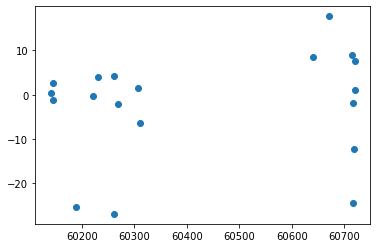

In [88]:
plt.plot(df["time"], df["flux"], 'o')